In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import xml.etree.ElementTree as xet

In [2]:
df = pd.read_csv("dataset/label.csv")

df.head()

,filepath,xmin,xmax,ymin,ymax
0,dataset/data\N1.xml,1093,1396,645,727
1,dataset/data\N100.xml,134,301,312,350
2,dataset/data\N101.xml,31,139,128,161
3,dataset/data\N102.xml,164,316,216,243
4,dataset/data\N103.xml,813,1067,665,724


In [3]:
filename = df["filepath"][0]
filename

'dataset/data\\N1.xml'

In [4]:
xet.parse(filename).getroot().find("filename").text

'N1.jpeg'

In [5]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find("filename").text
    filepath_image = os.path.join("dataset/data",filename_image)
    return filepath_image

In [6]:
getFilename(filename)

'dataset/data\\N1.jpeg'

In [7]:
images_path = list(df["filepath"].apply(getFilename))
images_path[:5]

['dataset/data\\N1.jpeg',
 'dataset/data\\N100.jpeg',
 'dataset/data\\N101.jpeg',
 'dataset/data\\N102.jpeg',
 'dataset/data\\N103.jpeg']

## Verify Image 

(-0.5, 1919.5, 1079.5, -0.5)

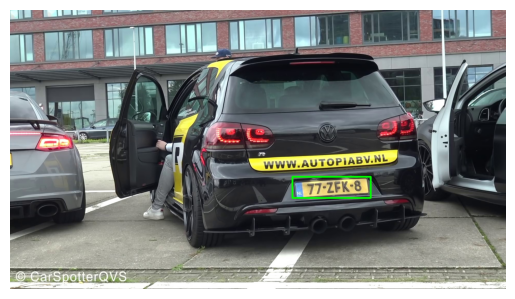

In [8]:
filepath = images_path[0]

img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2.rectangle(img, (1093,645), (1396,727), (0,255,0), 5)
plt.imshow(img)
plt.axis("off")

## Data Preprocessing

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [10]:
labels = df.iloc[:,1:].values
labels[:5]

array([[1093, 1396,  645,  727],
       [ 134,  301,  312,  350],
       [  31,  139,  128,  161],
       [ 164,  316,  216,  243],
       [ 813, 1067,  665,  724]], dtype=int64)

In [11]:
data = []
output = []
for ind in range(len(images_path)):
    ind = 0
    image = images_path[ind]
    image_arr = cv2.imread(image)
    h,w,d = image_arr.shape

    # preprocessing
    load_image = load_img(image, target_size=(224,224))
    load_img_arr = img_to_array(load_image)
    norm_load_img_arr = load_img_arr/255.0 # normalization

    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w, xmax/w
    nymin,nymax = ymin/h, ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    
    # append
    data.append(norm_load_img_arr)
    output.append(label_norm)    

In [12]:
X = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)

In [13]:
X.shape, y.shape

((225, 224, 224, 3), (225, 4))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

## Deep Learning Model

In [15]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [16]:
inception_resnet = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

inception_resnet.trainable = False

### NETWORK ###
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(512, activation="relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(64, activation="relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(32, activation="relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(4, activation="sigmoid")(headmodel)

### MODEL ###
model = Model(inputs=inception_resnet.input, outputs=headmodel)

In [17]:
### COMPILE THE MODEL ###
model.compile(loss="mse", optimizer=tf.optimizers.Adam(learning_rate=1e-4))
#model.summary()

## Training

In [18]:
from tensorflow.keras.callbacks import TensorBoard

In [19]:
tfb = TensorBoard(log_dir="logs")

In [20]:
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test), callbacks=[tfb])

Epoch 1/150
12/12 [==============================] - 45s 2s/step - loss: 0.1683 - val_loss: 0.0392
Epoch 2/150
12/12 [==============================] - 21s 2s/step - loss: 0.1563 - val_loss: 0.0487
Epoch 3/150
12/12 [==============================] - 22s 2s/step - loss: 0.1328 - val_loss: 0.0100
Epoch 4/150
12/12 [==============================] - 21s 2s/step - loss: 0.1043 - val_loss: 0.0047
Epoch 5/150
12/12 [==============================] - 21s 2s/step - loss: 0.0496 - val_loss: 0.0192
Epoch 6/150
12/12 [==============================] - 21s 2s/step - loss: 0.0236 - val_loss: 0.0222
Epoch 7/150
12/12 [==============================] - 22s 2s/step - loss: 0.0229 - val_loss: 0.0220
Epoch 8/150
12/12 [==============================] - 22s 2s/step - loss: 0.0220 - val_loss: 0.0205
Epoch 9/150
12/12 [==============================] - 22s 2s/step - loss: 0.0220 - val_loss: 0.0196
Epoch 10/150
12/12 [==============================] - 23s 2s/step - loss: 0.0213 - val_loss: 0.0197
Epoch 11/

12/12 [==============================] - 21s 2s/step - loss: 0.0049 - val_loss: 0.0021
Epoch 84/150
12/12 [==============================] - 21s 2s/step - loss: 0.0058 - val_loss: 0.0021
Epoch 85/150
12/12 [==============================] - 21s 2s/step - loss: 0.0049 - val_loss: 0.0020
Epoch 86/150
12/12 [==============================] - 21s 2s/step - loss: 0.0054 - val_loss: 0.0019
Epoch 87/150
12/12 [==============================] - 22s 2s/step - loss: 0.0049 - val_loss: 0.0018
Epoch 88/150
12/12 [==============================] - 21s 2s/step - loss: 0.0056 - val_loss: 0.0017
Epoch 89/150
12/12 [==============================] - 21s 2s/step - loss: 0.0050 - val_loss: 0.0017
Epoch 90/150
12/12 [==============================] - 21s 2s/step - loss: 0.0052 - val_loss: 0.0016
Epoch 91/150
12/12 [==============================] - 20s 2s/step - loss: 0.0052 - val_loss: 0.0016
Epoch 92/150
12/12 [==============================] - 21s 2s/step - loss: 0.0045 - val_loss: 0.0015
Epoch 93/150


In [21]:
model.save("dataset/object_detection_v2.h5")